# Breast Cancer 데이터셋을 활용한 다층 퍼셉트론 모델 이진분류

- 목차    
   
    0. 라이브러리 import
    1. 데이터 준비
       - 1-1. 학습/검증/테스트 데이터 분리
       - 1-2. 데이터 표준화
       - 1-3. Tensor 데이터 변환
    2. 미니 배치
    3. 모델 준비 (DNN)
    4. 학습 및 평가 함수 및 클래스
        - 4-1. 학습 함수
        - 4-2. 평가 함수
        - 4-3. Early Stopping
        - 4-4. 학습 및 검증을 수행하는 함수
    5. Optuna 하이퍼파라미터 튜닝
    6. 최적의 파라미터로 재학습
    7. 시각화

# 0. 라이브러리 import

In [77]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer      # 유방암 데이터셋 예제
from sklearn.model_selection import train_test_split # 학습/검증/테스트 데이터셋 분리
from sklearn.preprocessing import StandardScaler     # 입력 특성 표준화(z-score)
from sklearn.metrics import (
    accuracy_score,          # 정확도
    roc_auc_score,           # ROC-AUC 점수
    roc_curve,               # ROC 곡선 좌표 계산
    confusion_matrix,        # 혼동 행렬
    ConfusionMatrixDisplay,  # 혼동 행렬 시각화
)

import torch                 # Tensor 조작 및 Pytorch 기본 패키지
import torch.nn as nn        # 신경망 레이어 및 모델 정의
import torch.optim as optim  # 최적화 함수 (SGD, Adam 등)
from torch.utils.data import TensorDataset, DataLoader # Dataset 구성 및 미니배치 로딩

import optuna   # 하이퍼파라미터 최적화
import warnings # 파이썬 경고 메시지 제어
warnings.filterwarnings('ignore') # 불필요한 warning 메시지 제거

# 1. 데이터 준비

###   1-1. 학습/검증/테스트 데이터 분리

In [78]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

print(f"X는 {X.shape}, y는 {y.shape}")

X는 (569, 30), y는 (569,)


In [79]:
# Test 데이터 분리 (모델 최종 성능 평가용)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size = 0.2,   # 전체 데이터의 20%를 Test 데이터로 분리
    random_state = 42, # 재현가능성 (시드 설정)
    stratify = y       # 클래스 비율을 유지하면서 분할
)

print(
    f"X_trainval은 {X_trainval.shape},\n"
    f"x_test는 {X_test.shape},\n"
    f"y_trainval은 {y_trainval.shape},\n"
    f"y_test는 {y_test.shape}"
    )

X_trainval은 (455, 30),
x_test는 (114, 30),
y_trainval은 (455,),
y_test는 (114,)


In [80]:
# Train/Validation 분리 (하이퍼파라미터 튜닝 / 과적합 체크용)

# 입력데이터, 타겟데이터, 비율은 0.25, seed = 42, stratify = y_trainval
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size = 0.25,       # 전체 데이터의 25%를 Validation 데이터로 분리
    random_state = 42,      # 재현가능성 (시드 설정)
    stratify = y_trainval   # 클래스 비율을 유지하면서 분할
)

print(
    f"X_train은 {X_train.shape},\n"
    f"X_val은 {X_val.shape},\n"
    f"y_train은 {y_train.shape},\n"
    f"y_val은 {y_val.shape}"
    )

X_train은 (341, 30),
X_val은 (114, 30),
y_train은 (341,),
y_val은 (114,)


### 1-2. 데이터 표준화

In [81]:
# 입력 데이터 표준화 (StandardScaler : 평균 0, 표준편차 1로 스케일 조정)
# ℹ️MinMaxScaler : 0과 1 사이의 값으로 스케일 조정

# scaler 객체 호출
scaler = StandardScaler()

# X_train, X_val, X_test 데이터를 학습 및 변환.
X_train = scaler.fit_transform(X_train) # train 데이터는 fit(학습) 후 transform(변환)
X_val = scaler.transform(X_val)         # val 데이터는 학습데이터가 학습한 기준으로 transform만 진행
X_test = scaler.transform(X_test)       # test 데이터는 학습데이터가 학습한 기준으로 transform만 진행

### 1-3. Tensor 데이터 변환

In [82]:
# Numpy 배열 -> Pytorch Tensor 변환 (모델 학습을 위한 float 타입 변환)
X_train_t = torch.tensor(X_train, dtype=torch.float32)         # (N, D) 형태 입력 텐서
X_val_t = torch.tensor(X_val, dtype=torch.float32)             # (N, D) 형태 유지
X_test_t = torch.tensor(X_test, dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(X_train_t.shape, y_train_t.shape)

torch.Size([341, 30]) torch.Size([341, 1])


## 2. 미니 배치

In [83]:
# 학습, 검증, 테스트용 DataLoader 를 생성하는 함수 
# (학습 데이터는 shuffle, 검증 및 테스트 데이터는 고정된 순서로 사용하는 것이 기본 원칙)
def make_loader(batch_size=64):
    train_loader = DataLoader(
        TensorDataset(X_train_t, y_train_t),  # 학습용 입력(X)와 정답(y) 묶기
                    batch_size = batch_size,  # 미니배치 크기 설정
        shuffle = True                        # 학습 데이터는 랜덤으로 섞어 일반화 성능 향상
    )

    val_loader = DataLoader(
        TensorDataset(X_val_t, y_val_t),
        batch_size = batch_size,
        shuffle = False                       # 검증 데이터는 순서 고정
    )

    test_loader = DataLoader(
        TensorDataset(X_test_t, y_test_t),
        batch_size = batch_size,
        shuffle = False                       # 테스트 데이터도 순서 고정
    )

    return train_loader, val_loader, test_loader # 세 종류의 DataLoader 반환

### 3. 모델 준비 (DNN)

In [84]:
# 다층 퍼셉트론(MLP) 이진 분류용 모델 (출력은 logit 1개)
class MLP(nn.Module):

    def __init__(self, input_dim, hidden_dim1 = 64, hidden_dim2 = 32, dropout_p = 0.0):
        super().__init__()  # nn.Module 초기화 (수동 상태 추적)

        self.fc1 = nn.Linear(input_dim, hidden_dim1)   # 입력 -> 첫번째 은닉층
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2) # 두번째 은닉층
        self.fc_out = nn.Linear(hidden_dim2, 1)        # 출력층 (logit 1개)

        self.act = nn.ReLU()   # 활성화 함수
        self.dropout = nn.Dropout(dropout_p) if dropout_p > 0 else nn.Identity() # Dropout값 설정 또는 통과

    def forward(self, x):
        x= self.act(self.fc1(x))   # 첫번째 은닉층 + ReLU
        x = self.dropout(x)        # Dropout 적용 (선택)
        x = self.act(self.fc2(x))  # 두번째 은닉층 + ReLU
        x = self.dropout(x)        # Dropout 적용 (선택)
        x = self.fc_out(x)         # 출력층. 최종 출력 (logit)
        return x                   # shape : (batch_size, 10

## 4. 학습 및 평가 함수 및 클래스

### 4-1. 학습 함수

In [85]:
criterion = nn.BCEWithLogitsLoss()  # 이진분류 손실함수 : 로짓 입력받고 내부에서 Sigmoid + BCE 처리

def train_one_epoch(model, loader, optimizer):
    model.train()  # 학습 모드 전환 (Dropout/BatchNorm 등이 있다면 적용)
    losses = []    # 배치별 loss를 저장할 리스트

    for xb, yb in loader:  # 미니배치 단위로 (입력, 정답) 반복
        logits = model(xb) # 순전파 : 모델 출력(logit) 계산
        loss = criterion(logits, yb)  # 예측(logit)과 정답(0/1)으로 BCE 손실 계산
        
        optimizer.zero_grad()  # 이전 step 기울기 초기화
        loss.backward()        # 역전파 : 현재 loss 기준으로 기울기 계산
        optimizer.step()       # 계산된 기울기로 파라미터(가중치/편향) 업데이트        
        losses.append(loss.item())  # 파이썬 숫자 형태로 loss 값 저장
    
    return float(np.mean(losses))   # 1 epoch 동안의 평균 train_loss 반환

### 4-2. 평가 함수

In [86]:
@torch.no_grad                              # 데코레이터 방식 : 평가시 gradient 계산 비활성화 (속도 향상, 메모리 절약)
def evaluate(model, loader):
    model.eval()                            # 평가모드로 전환 (dropout 비활성화, batchNorm 고정 통계 사용 - 비활성화)
    losses =[]                              # 배치별 loss 누적
    y_true_all = []                         # 실제 정답 누적 저장
    y_prob_all = []                         # 예측 확률 누적 저장

    for xb, yb in loader:                   # 미니배치 단위로 반복
        logits = model(xb)                  # 순전파 : 모델 출력 계산
        loss = criterion(logits, yb)        # 검증/테스트 loss 계산
        prob = torch.sigmoid(logits)        # logit -> 확률(0~1) 변환

        losses.append(loss.item())            # loss 기록
        y_true_all.append(yb.cpu().numpy())   # 정답을 numpy로 변환해 누적
        y_prob_all.append(prob.cpu().numpy()) # 확률을 numpy로 변환해 누적

    y_true = np.vstack(y_true_all).ravel()    # (N, 1) -> (N,) 형태로 변환
    y_prob = np.vstack(y_prob_all).ravel()    # (N, 1) -> (N,) 형태로 변환
    y_pred = (y_prob > 0.5).astype(int)       # 임계값 0.5 기준으로 클래스 (0, 1) 결정

    acc = accuracy_score(y_true, y_pred)      # 정확도 계산
    auc = roc_auc_score(y_true, y_pred)       # ROC-AUC 계산 (확률 기반)

    return float(np.mean(losses)), acc, auc, y_true, y_prob  # 평균 loss, acc, auc, 정답, 확률 반환

데코레이터 방식   
@torch.no_grad()   
def evaluate():   
    ...   
   
==========   
   
def evaluate():   
width torch.no_grad():   
    ...   
   
- 데코레이터 방식을 사용하면 코드가 깔끔해진다

y_true = np.vstack(y_true_all).ravel()   
   
y_true_all = ]   
    array([1], [0], [1], ...), 첫번째 배치   
    array([0], [1], [0], ...), 두번째 배치   
]   
   
np.vstack(y_true_all)  # vstack = 세로로 붙이기 (배치들을 하나로 이어붙임)   
array([   
    [1],   
    [0],   
    [1],   
    [0],   
    [1],   
    [0],   
    [1],   
    [0],   
    ...   
])   
   
shape: (N, 1)   
   
.ravel() : 배열을 1차원으로 평탄화(flatten)   
array([1, 0, 1, 0, 1, 0, ...])   
shape: (N,)   
   
이걸 만드는 이유 : accuracy_score나 roc_auc_score 등 평가함수들이 1차원 배열을 매개값으로 받는다.   
== y_true = np.vstack(y_true_all).ravel()   
== y_true = np.vstack(y_true_all).reshape(-1)   
== y_true = np.vstack(y_true_all).flatten()

### 4-3. Early Stopping

In [87]:
# Early Stopping : 검증 손실이 더이상 개선되지 않으면 학습을 조기에 중단하는 클래스
class EarlyStopping:

    def __init__(self, patience = 20, min_delta = 0.0):
        self.patience = patience    # 성능 개선이 없어도 허용할 최대 epoch 수
        self.min_delta = min_delta  # 개선으로 인정할 최소 손실 감소량
        self.best = float('inf')    # 지금까지 중 가장 최고의 검증 손실
        self.counter = 0            # 연속으로 개선되지 않은 epoch 수
        self.stop = False           # 학습 중단 여부 (플래그)

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:  # 개선이 된다면
            self.best = val_loss                   # best 갱신
            self.counter = 0                       # 카운터 초기화
        else:
            self.counter += 1                      # 개선이 없으면 카운터 증가
            if self.counter >= self.patience:
                self.stop = True                   # patience 초과시 학습 중단

### 4-4. 학습 및 검증을 수행하는 함수

In [92]:
def fit(model, train_loader, val_loader, lr=1e-3, n_epochs = 200, weight_decay = 0.0):
    optimizer = optim.Adam(          # Adam 최적화함수 사용
        model.parameters(),          # 학습 대상 파라미터
        lr = lr,                     # 학습률
        weight_decay = weight_decay  # L2 정규화 (과적합 완화)
    )

    hist = {
        "train_loss" : [],
        "val_loss" : [],
        "val_acc" : [],
        "val_auc" : []
    }  # epoch별 기록 저장용 dict
    best_val = np.inf  # 현재까지의 최소 val_loss 저장
    bewst_state = None # best 모델 가중치 저장용

    early = EarlyStopping(patience = 20)  # 20번동안 개선사항이 없다면 조기종료 설정

    for epoch in range(1, n_epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer)    # 1 epoch 학습 후 train_loss qksghks
        va_loss, va_acc, va_auc, _, _ = evaluate(model, val_loader)  # 검증 loss, acc, auc 계산

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["val_acc"].append(va_acc)
        hist["val_auc"].append(va_auc)

        if va_loss < best_val:  # val_loss가 best_val보다 더 낮아지면
            best_val = va_loss  # 갱신
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()} # best 가중치 스냅샷 저장

        early.step(va_loss)     # 검증 손실 개선 여부를 확인해 early stopping 상태 갱신

        if early.stop:          # patience 만큼 개선이 없으면
            print(f"얼리스타핑 실행 에포크는 {epoch}")
            break               # 종료한다.

    if best_state is not None:
        model.load_state_dict(best_state)  # 저장해둔 best 가중치로 모델 복원

    return hist

## 5. Optuna 하이퍼파라미터 튜닝

In [93]:
def objective(trial):
    hidden_dim1 = trial.suggest_categorical("hidden_dim1", [32 ,64, 128, 256])  # 은닉층 1층 노드수
    hidden_dim2 = trial.suggest_categorical("hidden_dim2", [16 ,32, 64, 128])   # 은닉층 2층 노드수
    dropout_p = trial.suggest_float("dropout_p", 0.0, 0.5)                      # dropout 비율
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log = True)                      # 학습률 (log)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log = True)  # L2 정규화 (Log)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])         # 배치 크기
    
    train_loader, val_loader, _ = make_loader(batch_size = batch_size)          # loader 생성 (학습/검증)

    model = MLP(
        input_dim = X_train.shape[1],  # 입력 차원
        hidden_dim1 = hidden_dim1,     # 1층 노드 수
        hidden_dim2 = hidden_dim2,     # 2층 노드 수
        dropout_p = dropout_p          # dropout 비율
    )

    hist = fit(
        model, train_loader, val_loader,
        lr = lr,        # 학습률
        n_epochs = 150, # 최대 epoch
        weight_decay = weight_decay,  # L2 정규화 : 쓸데없는 가중치를 0에 가깝게 유지하면서 0으로 만들지는 않는다.
    )

    best_val_auc = float(np.max(hist["val_auc"])) # 최고 val AUC 반환

    return best_val_auc                           # Optuna가 최적화할 목적함수

study = optuna.create_study(direction = "maximize") # 목적함수(val_auc)를 최대화하도록 Optuna Study 생성
study.optimize(objective, n_trials = 30)            # objective 함수를 30번 실행하며 최적의 하이퍼파라미터 탐색

print("Optuna Best Params :", study.best_params)    # 최적의 하이퍼파라미터 조합
print("Optuna Best Value (Val_auc) :", study.best_value)  # 해당 파라미터에서의 최고 검증 AUC 출력

[I 2026-01-05 16:31:45,636] A new study created in memory with name: no-name-97ac91d0-bc4a-495b-9e4d-0bb7e77fc04d
[I 2026-01-05 16:31:46,845] Trial 0 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 128, 'dropout_p': 0.48268967239361404, 'lr': 0.0019934189531278005, 'weight_decay': 6.180396507293932e-05, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:47,030] Trial 1 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 64, 'dropout_p': 0.2444058751830503, 'lr': 0.009723380362986958, 'weight_decay': 0.0003584759809379533, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 54
얼리스타핑 실행 에포크는 33


[I 2026-01-05 16:31:47,710] Trial 2 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 128, 'dropout_p': 0.10398215158748075, 'lr': 0.00020395739320835457, 'weight_decay': 8.902188845796555e-06, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 101


[I 2026-01-05 16:31:47,989] Trial 3 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 64, 'dropout_p': 0.39336022486513184, 'lr': 0.0012349015224736078, 'weight_decay': 1.1748394715278172e-06, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 63


[I 2026-01-05 16:31:48,612] Trial 4 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 32, 'dropout_p': 0.027737383722630682, 'lr': 0.00020025328476299938, 'weight_decay': 4.530566887282121e-06, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:49,480] Trial 5 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 128, 'dropout_p': 0.45857342068024565, 'lr': 0.0003125968012809655, 'weight_decay': 2.2171318293234155e-06, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 116


[I 2026-01-05 16:31:50,092] Trial 6 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 128, 'dropout_p': 0.34238922527799365, 'lr': 0.000496339395207137, 'weight_decay': 5.8404992829047015e-05, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:50,663] Trial 7 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 64, 'dropout_p': 0.4417583402033992, 'lr': 0.00016257255767625342, 'weight_decay': 1.0000077290155529e-05, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:51,060] Trial 8 finished with value: 0.9767441860465117 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 16, 'dropout_p': 0.3708670563907485, 'lr': 0.0014162274180433085, 'weight_decay': 2.5296572105100195e-05, 'batch_size': 128}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:51,515] Trial 9 finished with value: 0.9813298395021289 and parameters: {'

얼리스타핑 실행 에포크는 84
얼리스타핑 실행 에포크는 36


[I 2026-01-05 16:31:51,865] Trial 11 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.2181175353951183, 'lr': 0.004063604317651019, 'weight_decay': 0.00011576504005562317, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:52,026] Trial 12 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.1810184531354126, 'lr': 0.0035748146786244443, 'weight_decay': 0.00014957204048393253, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 43
얼리스타핑 실행 에포크는 36


[I 2026-01-05 16:31:52,195] Trial 13 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 128, 'dropout_p': 0.31526851635556485, 'lr': 0.0037287113606384284, 'weight_decay': 3.444723174332152e-05, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 31


[I 2026-01-05 16:31:52,422] Trial 14 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.14988317466230172, 'lr': 0.009079652848764245, 'weight_decay': 0.0002439257595050801, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 30


[I 2026-01-05 16:31:52,929] Trial 15 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 128, 'dropout_p': 0.4994843483821673, 'lr': 0.0006475658911169499, 'weight_decay': 0.0007833614352664605, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 97


[I 2026-01-05 16:31:53,250] Trial 16 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.29175801612843755, 'lr': 0.0024345522631843146, 'weight_decay': 6.318440627696729e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:53,398] Trial 17 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 16, 'dropout_p': 0.08062930807378907, 'lr': 0.006183322990124758, 'weight_decay': 1.8269578567658606e-05, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 50
얼리스타핑 실행 에포크는 34


[I 2026-01-05 16:31:53,826] Trial 18 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 128, 'dropout_p': 0.2705721232378142, 'lr': 0.0008238414484072834, 'weight_decay': 7.294756388137614e-05, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:54,023] Trial 19 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.2101365088349176, 'lr': 0.002484184968080901, 'weight_decay': 0.00013884198779092212, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 84
얼리스타핑 실행 에포크는 44


[I 2026-01-05 16:31:54,219] Trial 20 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 128, 'dropout_p': 0.12009401578369097, 'lr': 0.005837098881911455, 'weight_decay': 0.0009326976451006709, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:54,374] Trial 21 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.22204260122793312, 'lr': 0.00418009645224979, 'weight_decay': 0.00012902280409729275, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 26
얼리스타핑 실행 에포크는 34


[I 2026-01-05 16:31:54,640] Trial 22 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.18174819941895665, 'lr': 0.0024234889752254027, 'weight_decay': 0.00023109543144911483, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 41


[I 2026-01-05 16:31:55,310] Trial 23 finished with value: 0.9626596790042582 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.32018282998430775, 'lr': 0.00010194339769888398, 'weight_decay': 5.080987396799285e-05, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.
[I 2026-01-05 16:31:55,526] Trial 24 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.26795997477589495, 'lr': 0.006652182377737558, 'weight_decay': 0.00011408301205367145, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 49


[I 2026-01-05 16:31:55,756] Trial 25 finished with value: 0.9813298395021289 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 32, 'dropout_p': 0.17853715645943932, 'lr': 0.0017735909664781714, 'weight_decay': 1.767810347016187e-05, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 52


[I 2026-01-05 16:31:55,997] Trial 26 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 64, 'dropout_p': 0.04765753677398882, 'lr': 0.004451698585913936, 'weight_decay': 0.0002575787026305022, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 28


[I 2026-01-05 16:31:56,239] Trial 27 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 16, 'dropout_p': 0.2391409160785229, 'lr': 0.002999851570599496, 'weight_decay': 8.691516116400902e-05, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 60


[I 2026-01-05 16:31:56,734] Trial 28 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 32, 'dropout_p': 0.35428311519833233, 'lr': 0.0010273381617759926, 'weight_decay': 3.6012182935544676e-05, 'batch_size': 32}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 76


[I 2026-01-05 16:31:56,966] Trial 29 finished with value: 0.9883720930232558 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 64, 'dropout_p': 0.2543411272589687, 'lr': 0.009713045025738958, 'weight_decay': 0.00044028472634025394, 'batch_size': 64}. Best is trial 0 with value: 0.9883720930232558.


얼리스타핑 실행 에포크는 38
Optuna Best Params : {'hidden_dim1': 128, 'hidden_dim2': 128, 'dropout_p': 0.48268967239361404, 'lr': 0.0019934189531278005, 'weight_decay': 6.180396507293932e-05, 'batch_size': 64}
Optuna Best Value (Val_auc) : 0.9883720930232558


## 6. 최적의 파라미터로 재학습

In [97]:
best = study.best_params   # optuna가 찾은 최적의 하이퍼파라미터 가져옴

train_loader, val_loader, test_loader = make_loader(  # 최적의 배치크기로 DataLoader 생성
    batch_size = best["batch_size"]
)

best_model = MLP(
    input_dim = X_train.shape[1],      # 입력 차원 수(X의 특성 갯수)
    hidden_dim1 = best["hidden_dim1"], # 최적의 첫 번째 은닉층 노드 수
    hidden_dim2 = best["hidden_dim2"], # 최적의 두 번재 은닉층 노드 수
    dropout_p = best["dropout_p"],     # 최적 dropout 비율
)

history = fit(
    best_model,
    train_loader, val_loader,           # train/val 로더 사용
    lr = best["lr"],                    # 최적의 학습률 사용
    n_epochs = 300,
    weight_decay = best["weight_decay"] # 최적의 L2 정규화 규제 수치 적용
)

# 학습이 끝난 모델로 test 데이터 평가
test_loss, test_acc, test_auc, y_true, y_prob = evaluate(best_model, test_loader) 

print(
    f"""
    로스: {test_loss:.4f}
    정확도: {test_acc}
    에이유씨: {test_auc:.4f}""")

얼리스타핑 실행 에포크는 51

    로스: 0.1120
    정확도: 0.9473684210526315
    에이유씨: 0.9534


## 7. 시각화

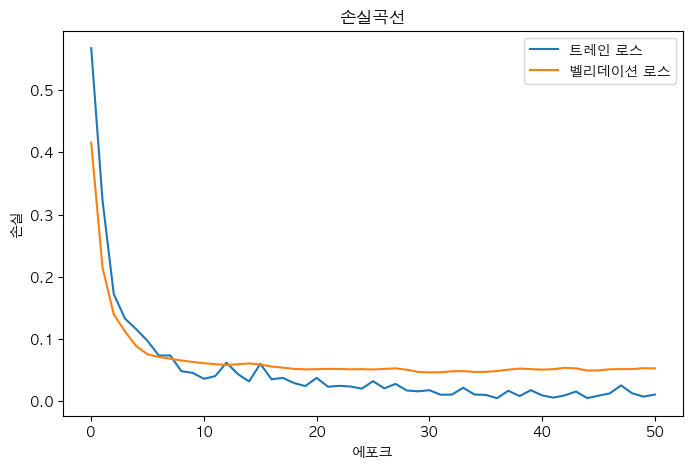

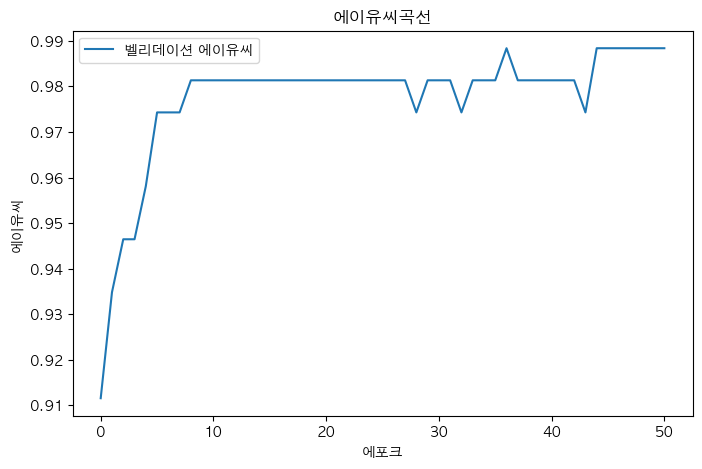

In [104]:
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 학습 곡선 (Train/Val Loss/Val AUC)
plt.figure(figsize=(8, 5))
plt.plot(history['train_loss'], label='트레인 로스')
plt.plot(history['val_loss'], label='벨리데이션 로스')
plt.xlabel("에포크")
plt.ylabel("손실")
plt.title("손실곡선")
plt.legend()
plt.show()

# 학습 곡선 (Train/Val Loss/Val AUC)
plt.figure(figsize=(8, 5))
plt.plot(history['val_auc'], label='벨리데이션 에이유씨')
plt.xlabel("에포크")
plt.ylabel("에이유씨")
plt.title("에이유씨곡선")
plt.legend()
plt.show()

- 손실 곡선 (Loss Curve) : 과적합 여부 확인
    - 학습 손실과 검증 손실의 차이를 통해 모델이 학습 데이터를 과도하게 외우고 있는지 판단
    - 학습 손실 곡선은 계속 감소하면서, 검증 손실이 증가하면 과적합의 신호
   
- AUC 곡선 (AUC Curve) : 분류 성능의 개선 추이를 확인
    - 모델의 전반적인 분류 능력이 학습 과정에서 어떻게 변화하는지 확인
    - auc가 꾸준히 증가하면 클래스 간 구분 능력이 향상되고 있음을 의미
    - 정체되거나 하락하면 추가학습이 성능 개선으로 이어지지 않음을 의미

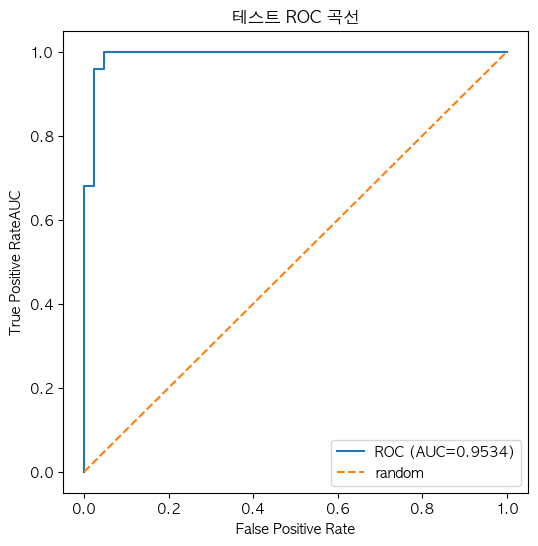

In [107]:
# ROC 곡선 (fpr: False Positive Rate, tpr: True Positive RateAUC , thr : 임계값)
fpr, tpr, thr, = roc_curve(y_true, y_prob)  #실제값(Y_True)와 예측 확률(y_prob)으로 ROC 곡선 좌표 계산

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC={test_auc:.4F})")  # 모델의 ROC 곡선 및 AUC 값 표시
plt.plot([0, 1],[0, 1], linestyle='--', label='random')   # 대각선 (기준선)
plt.xlabel('False Positive Rate')                           # X축 : 거짓 양성 비율
plt.ylabel('True Positive RateAUC')                             # Y축 : 참 양성 비율
plt.title('테스트 ROC 곡선')                                        # 제목
plt.legend()                                                            # 범례
plt.show()

- ROC 곡선 : 분류 임계값 변화에 따른 모델의 판별 성능을 시각적으로 평가하는 지표
    - AUC가 클수록 성능이 좋다.
    - 분류 기준 임계값을 0 ~ 1 사이에서 변화시키면서, 거짓 양성 비율(FPR)과 참 양성 비율(TPR)의 관계를 나타낸다.
    - 이 모델이 양성과 음성을 얼마나 잘 구분하는지를 확인할 수 있다.
    - AUC는 ROC 곡선 아래 면적으로, 무작위로 하나의 양성과 음성을 선택했을 때 모델이 올바르게 순서를 매길 확률을 해석할 수 있다.

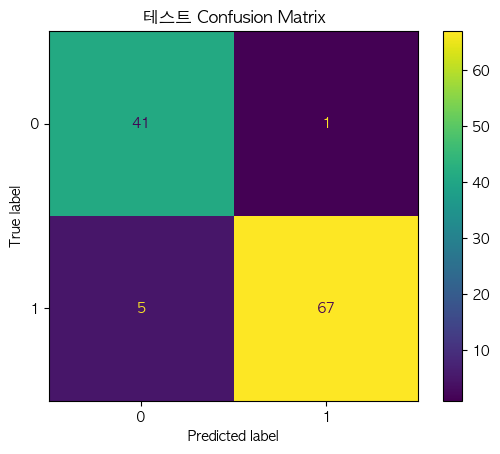

In [108]:
# 혼동행렬(Confusion Matrix)
y_pred = (y_prob > 0.5).astype(int)                   # 임계값 0.5 기준으로 이진 클래스 (0/1)로 변환
cm = confusion_matrix(y_true, y_pred)                 # 실제값과 예측값을 비교해 혼동행렬 계산
disp = ConfusionMatrixDisplay(confusion_matrix=cm)    # 혼동행렬 시각화 객체 생성
disp.plot()                                           # 혼동행렬 시각화
plt.title('테스트 Confusion Matrix')
plt.show()

- 혼동행렬은 각 클래스별로 얼마나 맞추고 틀렸는지를 숫자로 보여준다.   
그래서 모델의 오류 유형을 분석하는데 용이하다.

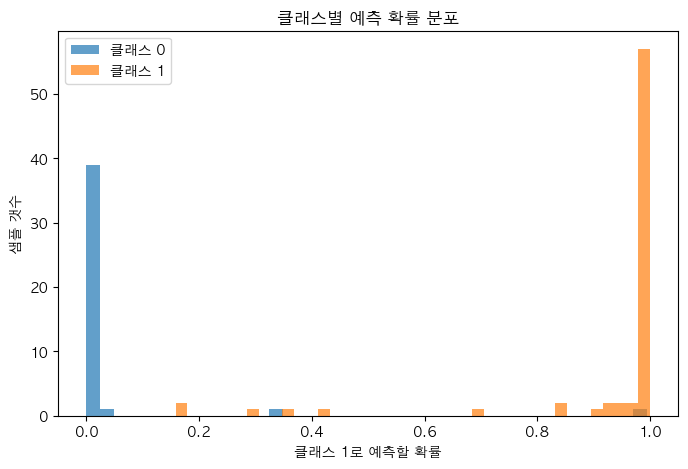

In [109]:
# 클래스별 예측 확률 분포
plt.figure(figsize=(8, 5))
plt.hist(
    y_prob[y_true == 0],
    bins = 40,
    alpha = 0.7,
    label = "클래스 0"
)
plt.hist(
    y_prob[y_true == 1],
    bins = 40,
    alpha = 0.7,
    label = "클래스 1"
)

plt.xlabel("클래스 1로 예측할 확률")
plt.ylabel("샘플 갯수")
plt.title("클래스별 예측 확률 분포")
plt.legend()
plt.show()


- 클래스별 예측 확률 분포는 모델이 두 클래스를 얼마나 명확하게 구분하고 있는지를 보여주는 시각화 자료이다.
    - x축 : 모델이 클래스 1일 확률이라고 예측한 값
    - 색상  : 파랑색(실제 클래스 0), 주황색(실제 클래스 1)
    - 틀린예측
        - 파랑색에 있는 주황색 => 모델이 클래스 1을 클래스 0으로 판단 (False Negative)
        - 주황색에 있는 파랑색 => 모델이 클래스 0을 클래스 1로 판단 (False Negative)
    - 현재 상태 : 나쁘지 않은 상태 (분류 경계는 명확, 모델의 확신도 높다. AUC가 높을 가능성이 크다.)

### 분류모델에서 성능을 끌어올리기 위한 기법   
1. 은닉층 변경
2. 하이퍼파라미터 최적화 (Optuna)
3. 최적화 함수 변경 (Adam -> AdamW, Nadam, RAdam)
4. 스케일러 변경 (StandardScaler -> MinMaxScaler, RobustScaler)
5. 클래스 불균형 해소 (SMOTE) : 데이터 증강

### 과적합 회피 기법   
1. Dropout or BatchNorm   
2. Scheduler: 점진적으로 lr 제거 (ReduceLROnPlateau)
3. EarlyStopping
4. K-fold Cross Validation (k번 분할해서 평가 진행)